In [1]:
import pickle
from aemulusnu_massfunction.emulator import *
from aemulusnu_massfunction.fisher_utils import *

with open('cluster_abundance_fiducial_covariance.pkl', 'rb') as file:
    cluster_count_cov = pickle.load(file)

In [2]:
# import pickle
# from emulator import *
# from fisher_utils import *

# with open('cluster_abundance_fiducial_covariance_shot_noise_only.pkl', 'rb') as file:
#     cluster_count_cov = pickle.load(file)

In [3]:
z_bin_edges = [0.2, 0.4, 0.6, 0.8, 1.0]
richness_bin_edges = [20., 30., 45., 60., 300.]

n_z = len(z_bin_edges) - 1
n_r = len(richness_bin_edges) - 1
cov_matrix_2d = np.zeros((n_z * n_r, n_z * n_r))

for i in range(n_z):
    for j in range(n_z):
        for a in range(n_r):
            for b in range(n_r):
                row_index = i * n_r + a
                col_index = j * n_r + b
                cov_matrix_2d[row_index, col_index] = cluster_count_cov[i, j, a, b]

                
                
from scipy.linalg import cho_factor, cho_solve
cholesky_factor = cho_factor(cov_matrix_2d)
cov_inv = cho_solve(cholesky_factor, np.eye(n_z * n_r))                


In [4]:
dμdθ = {}
dμdθ_unflat = {}

for parameter_changed in fiducial_log10_rel_step_size:
    cluster_abundance_pos = None
    cluster_abundance_neg = None
    log10_rel_step_size = fiducial_log10_rel_step_size[parameter_changed]
    fname_base = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/cluster_abundance_fisher_%s_%.4f'%(parameter_changed, log10_rel_step_size)
    with open(fname_base, 'rb') as file:
        cluster_abundance_pos = pickle.load(file)
    with open(fname_base+'_neg', 'rb') as file:
        cluster_abundance_neg = pickle.load(file)
    h = np.abs(fiducial_cosmology[parameter_changed]) * 10**log10_rel_step_size
    tmp_theory_deriv = (cluster_abundance_pos - cluster_abundance_neg) / (2 * h)
    flattened_theory_deriv = np.zeros((n_z * n_r))
    for i in range(n_z):
        for a in range(n_r):
            flattened_theory_deriv[i * n_r + a] = tmp_theory_deriv[i, a]
    dμdθ[parameter_changed] = flattened_theory_deriv
    dμdθ_unflat[parameter_changed] = tmp_theory_deriv


In [5]:
# N_fiducial = N_in_z_bins_and_richness_bins(fiducial_cosmology, richness_bin_edges, z_bin_edges)
# flattened_N_fid = np.zeros((n_z * n_r))

# for i in range(n_z):
#         for a in range(n_r):
#             flattened_N_fid[i * n_r + a] = N_fiducial[i, a]

In [6]:
labels = {
    '10^9 As': r'$10^9A_s$',
    'ns': r'$n_s$',
    'H0': r'$H_0$',
    'w0': r'$w_0$',
    'ombh2': r'$\Omega_b h^2$',
    'omch2': r'$\Omega_c h^2$',
    'nu_mass_ev': r'$\sum m_\nu$',
    'sigma8' : r'$\sigma_8$'
}

In [7]:
# param = 'nu_mass_ev'
# tmp_dlnN_dlnθ = dμdθ_unflat[param] * fiducial_cosmology[param] / N_fiducial
# tmp_dlnN_dlnθ = np.reshape(tmp_dlnN_dlnθ, (4,4))
# import matplotlib.pyplot as plt
# plt.rcParams['text.usetex'] = True
# plt.rcParams['font.size'] = 32
# plt.rcParams['font.family'] = 'serif'

# plt.figure(figsize=(8,8))
# plt.imshow((tmp_dlnN_dlnθ), cmap='rainbow')
# plt.colorbar()
# plt.xticks([])
# plt.yticks([])
# plt.title(r'$d \ln \mathcal N^i_{\lambda_\alpha} / d \ln $%s'%(labels[param]))

In [8]:
# import matplotlib.pyplot as plt
# import numpy as np

# params = list(dμdθ.keys())
# print(len(params))
# n_rows = 2 # Adjust based on the number of keys
# n_cols = 4 # Adjust based on the number of keys

# fig, axs = plt.subplots(n_rows, n_cols, figsize=(32,16), sharex=True, sharey=True)
# cbar_ax = fig.add_axes([0.91, 0.15, 0.02, 0.7]) # Adjust to place the colorbar properly


# # Define labels for redshift and richness bins
# redshift_labels = ['0.2-0.4', '0.4-0.6', '0.6-0.8', '0.8-1.0']
# richness_labels = ['20-30', '30-45', '45-60', r'60-$\infty$']

# # Loop over the parameters and plot the images
# for i, param in enumerate(params):
#     row = i // n_cols
#     col = i % n_cols
#     ax = axs[row, col]

#     tmp_dlnN_dlnθ = dμdθ[param] * fiducial_cosmology[param] / flattened_N_fid
#     tmp_dlnN_dlnθ = np.reshape(tmp_dlnN_dlnθ, (4, 4))

#     im = ax.imshow(tmp_dlnN_dlnθ, cmap='rainbow')
#     ax.set_title(r'$d \ln \mathcal N^i_{\lambda_\alpha} / d \ln $ %s' % (labels[param]))
#     ax.set_xticks(range(4))
#     ax.set_xticklabels(richness_labels)
#     ax.set_yticks(range(4))
#     ax.set_yticklabels(redshift_labels)
#     if(row==1):
#         ax.set_xlabel('Richness Bin')
#     if(col==0):
#         ax.set_ylabel('Redshift Bin')
    
# # Common colorbar
# fig.colorbar(im, cax=cbar_ax)
# plt.savefig('dlnN_dlntheory.pdf')

In [9]:
n_parameters = len(fiducial_cosmology.keys())

fisher_matrix = np.zeros((n_parameters, n_parameters))

nu_mass_ev_idx = -1
for i, θi in enumerate(fiducial_cosmology.keys()):
    print(i, θi)
    if(θi == 'nu_mass_ev'):
        nu_mass_ev_idx = i
    for j, θj in enumerate(fiducial_cosmology.keys()):
        dμl_θi = dμdθ[θi]
        dμm_θj = dμdθ[θj]
        fisher_matrix[i,j] = np.einsum('l,lm,m', dμl_θi, cov_inv, dμm_θj)

0 10^9 As
1 ns
2 H0
3 w0
4 ombh2
5 omch2
6 nu_mass_ev


In [10]:
maximized = ['nu_mass_ev', 'ombh2', 'w0','H0','ns']
maximized_idxs = [list(fiducial_cosmology.keys()).index(c) for c in maximized]

In [11]:
for idx in reversed(sorted(maximized_idxs)):
    fisher_matrix = np.delete(fisher_matrix, idx, axis=0)  
    fisher_matrix = np.delete(fisher_matrix, idx, axis=1) 

    if(nu_mass_ev_idx >= idx):
        nu_mass_ev_idx -= 1

Text(0.5, 1.0, '$\\log_{10}$Fisher Matrix')

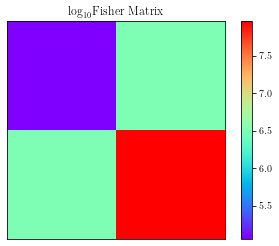

In [12]:
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 32
plt.rcParams['font.family'] = 'serif'

plt.imshow(np.log10(fisher_matrix), cmap='rainbow')
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.title(r'$\log_{10}$Fisher Matrix')


In [13]:
from scipy.linalg import cho_solve, cho_factor

# Compute the Cholesky decomposition
cholesky_factor = cho_factor(fisher_matrix)

# Solve for the inverse of the diagonal element
e_i = np.zeros_like(fisher_matrix[nu_mass_ev_idx])
e_i[nu_mass_ev_idx] = 1

inv_diagonal_element = cho_solve(cholesky_factor, e_i)[nu_mass_ev_idx]

In [14]:
inv_diagonal_element

1.8555693501609742e-06

In [15]:
inv_fisher_matrix = np.linalg.inv(fisher_matrix)


np.sqrt(inv_fisher_matrix[nu_mass_ev_idx][nu_mass_ev_idx])

0.0013621928461715258

In [16]:
print('%10s\t %25s\t %25s'%('parameter', 'σ(marginalized)/fid val', 'σ(unmarginalized)/fid val'))
print('----------------------------------------------------------------------------')
i=0
for θi in (fiducial_cosmology.keys()):
    if(θi in maximized):
        continue
    print('%10s\t %25.1e\t %25.1e'%(θi, np.abs(np.sqrt(inv_fisher_matrix[i,i])/fiducial_cosmology[θi]), np.abs(np.sqrt(fisher_matrix[i,i])**(-1)/fiducial_cosmology[θi])))
    i += 1

 parameter	   σ(marginalized)/fid val	 σ(unmarginalized)/fid val
----------------------------------------------------------------------------
   10^9 As	                   1.8e-02	                   1.4e-03
     omch2	                   1.1e-02	                   8.7e-04


In [17]:
print('%10s\t %25s'%('parameter', 'fid val +/- σ(marginalized)'))
print('----------------------------------------------------------------------------')
i=0
for θi in (fiducial_cosmology.keys()):
    if(θi in maximized):
        continue
    print('%10s\t %4.2f +/- %.3f'%(θi, (fiducial_cosmology[θi]),np.sqrt(inv_fisher_matrix[i,i])))
    i += 1

 parameter	 fid val +/- σ(marginalized)
----------------------------------------------------------------------------
   10^9 As	 2.10 +/- 0.039
     omch2	 0.12 +/- 0.001


Text(0.5, 1.0, 'Theory Covariance from (Fisher Matrix)$^{-1}$')

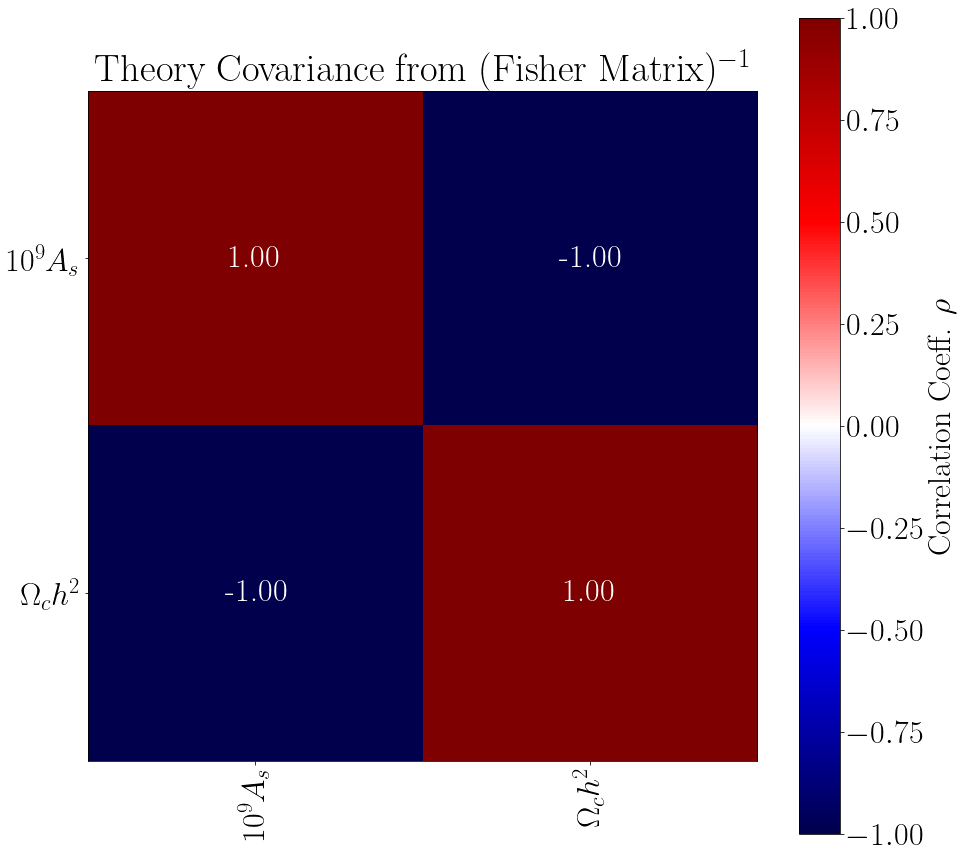

In [18]:
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 32
plt.rcParams['font.family'] = 'serif'
plt.figure(figsize=(15,15))

tmp_theory_cov =(inv_fisher_matrix)

# Compute the diagonal of the covariance matrix
diagonal = np.sqrt(np.diag(tmp_theory_cov))

# Calculate the correlation coefficient matrix
correlation_matrix = tmp_theory_cov / np.outer(diagonal, diagonal)

# Annotate cells with values
for i in range(correlation_matrix.shape[0]):
    for j in range(correlation_matrix.shape[1]):
        plt.text(j, i, f'{correlation_matrix[i, j]:.2f}', ha='center', va='center', color='white')

plt.imshow(correlation_matrix, cmap='seismic', vmin=-1, vmax=1)
plt.colorbar(label=r'Correlation Coeff. $\rho$')

tick_positions = np.arange(len(fiducial_cosmology) - len(maximized))
tick_labels = [labels[key] for key in fiducial_cosmology.keys() if key not in maximized]

plt.xticks(tick_positions, tick_labels, rotation='vertical')
plt.yticks(tick_positions, tick_labels)

plt.title(r'Theory Covariance from (Fisher Matrix)$^{-1}$')
# plt.savefig('fisher_forecasted_theory_cov.pdf')




In [ ]:
import seaborn as sns 


def corr2(cov1, cov2, label, label2):
    cmap='seismic'
    corr_nhat = np.copy(cov1)
    corr_nhat2 = np.copy(cov2)

    sze = len(correlation_matrix)
    mask = np.array([[0 for _ in range(sze)] for _ in range(sze)])
    for i in range(sze-1):
        for j in range(sze-1-i):
            corr_nhat[i][sze-j-1] = corr_nhat2[i][sze-j-1]
            mask[i][sze-j-1] = 1
    plt.figure(figsize=(15,15))
    print(np.shape(corr_nhat))
    print(np.shape(mask))

    ax = sns.heatmap(corr_nhat,  cmap=cmap, cbar=True, vmin=-1, vmax=1, square=True,
                    cbar_kws={ 'ticks':[],
                              "orientation": "horizontal", 'pad':-0.17, 'shrink':0.3})

    sns.heatmap(corr_nhat, mask=mask, cmap=cmap, cbar=True, ax=ax, vmin=-1, vmax=1,square=True,
           cbar_kws={'label': r"$\rho$","orientation": "horizontal", 'pad':0.1,  'shrink':0.3})


    tick_positions = np.arange(len(fiducial_cosmology) - len(maximized))+0.5
    tick_labels = [labels[key] for key in fiducial_cosmology.keys() if key not in maximized]

    ax.set_xticks(tick_positions, tick_labels, rotation='vertical')
    ax.set_yticks(tick_positions, tick_labels)

    for i in range(correlation_matrix.shape[0]):
        for j in range( correlation_matrix.shape[1]):
            ax.text(j+0.5, i+0.5, f'{corr_nhat[i, j]:.2f}', ha='center', va='center', color='white')


    plt.title(r'Correlations for {%s} (Bottom Left) and {%s} (Top Right)'%(label, label2))
    # if(common_norm):
    #     plt.title(r'Correlations for {%s} (Top Left) and {%s} (Bottom Right)'%(label, label2)+'\n'+'But correlation coefficient normalized to variance of %s'%(label))

    return ax


In [ ]:
label = r'Aemulus-$\nu$'
label2 = 'Sheth-Tormen'
corr2(correlation_matrix, st_correlation_matrix, label, label2)

In [ ]:
no_mnu_corr = None
with open('../4.5.fisher_forecast_no_mnu/fisher_cov.pkl', 'rb') as f:
    no_mnu_corr = pickle.load(f)

In [ ]:
label = r'Aemulus-$\nu$'
label2 = r'No $\sum m_\nu$'
corr2(correlation_matrix, no_mnu_corr, label, label2)